In [33]:
!pip install mediapipe


In [34]:
import mediapipe as mp
import cv2
import pandas as pd
import pickle
import numpy as np
import csv
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [35]:
# Determine important landmarks for squat
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE"
]

# Generate all columns of the data frame

landmarks = ["label"] # Label column

for lm in IMPORTANT_LMS:
    landmarks += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

In [36]:
def rescale_frame(frame, percent=50):

    width = int(frame.shape[1] * percent / 100)
    height = int(frame.shape[0] * percent / 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

def describe_dataset(dataset_path: str):

    # Load dataset
    data = pd.read_csv(dataset_path)

    # Print basic information about the dataset
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")

    # Check for missing values
    print(f"Missing values: {data.isnull().values.any()}\n")

    # Check for duplicate rows
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows: {len(duplicate)}\n")

    # Ensure numeric columns are properly converted to float
    numeric_columns = data.columns.drop('label')  # Assuming 'label' is non-numeric
    data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Print data types to verify conversions
    print("Column data types after conversion:")
    print(data.dtypes)

    # Check for any remaining NaN values after conversion
    if data.isnull().values.any():
        print(f"\nWarning: There are NaN values in the dataset after conversion.")
        print(data.isnull().sum())

    return data

In [37]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

In [38]:
df = describe_dataset("/content/train.csv")
df.head(3)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']
Number of rows: 4160 
Number of columns: 37

Labels: 
label
down    2127
up      2033
Name: count, dtype: int64

Missing values: False

Duplicate Rows: 0

Column data types after conversion:
label                object
nose_x              float64
nose_y              float64
nose_z              float64
nose_v              float64
left_shoulder_x     float64
left_shoulder_y     float64
left_shoulder_z     float6

,label,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,right_shoulder_x,...,right_knee_z,right_knee_v,left_ankle_x,left_ankle_y,left_ankle_z,left_ankle_v,right_ankle_x,right_ankle_y,right_ankle_z,right_ankle_v
0,down,0.600248,0.433268,-0.006637,0.999949,0.650759,0.517787,0.041632,0.994121,0.571711,...,-0.133012,0.976462,0.659328,0.836607,-0.294549,0.994219,0.575143,0.814380,-0.157936,0.966270
1,down,0.600160,0.449894,-0.008615,0.999966,0.651127,0.535333,0.036240,0.994432,0.571456,...,-0.115595,0.974204,0.659568,0.831231,-0.279601,0.993431,0.576560,0.812989,-0.135235,0.959162
2,down,0.599425,0.466234,-0.047636,0.999957,0.651464,0.550511,-0.021722,0.994265,0.571824,...,-0.084128,0.949108,0.659044,0.828410,-0.202085,0.987354,0.575949,0.813362,-0.053549,0.928765


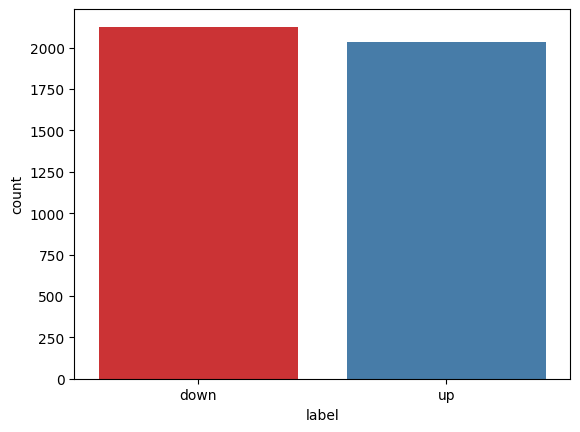

In [39]:

sns.countplot(x='label', data=df, palette="Set1")
df.loc[df["label"] == "down", "label"] = 0
df.loc[df["label"] == "up", "label"] = 1

In [40]:
# Extract features and class
X = df.drop("label", axis=1) # features
y = df["label"].astype("int")

sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))

In [41]:
# Split train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
y_test.head(3)

,label
3319,1
2621,0
3820,1


Logistic Regression

In [42]:
# Train and evaluate Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_model_results = lr_model.predict(X_test)

lr_p_score = precision_score(y_test, lr_model_results, average=None, labels=[0, 1])
lr_a_score = accuracy_score(y_test, lr_model_results)
lr_r_score = recall_score(y_test, lr_model_results, average=None, labels=[0, 1])
lr_f1_score_result = f1_score(y_test, lr_model_results, average=None, labels=[0, 1])
lr_cm = confusion_matrix(y_test, lr_model_results, labels=[0, 1])

lr_results = {
    "Model": "Logistic Regression",
    "Precision Score": round_up_metric_results(lr_p_score),
    "Accuracy Score": lr_a_score,
    "Recall Score": round_up_metric_results(lr_r_score),
    "F1 Score": round_up_metric_results(lr_f1_score_result),
    "Confusion Matrix": lr_cm
}

print(lr_results)


{'Model': 'Logistic Regression', 'Precision Score': [0.995, 1.0], 'Accuracy Score': 0.9975961538461539, 'Recall Score': [1.0, 0.995], 'F1 Score': [0.998, 0.998], 'Confusion Matrix': array([[427,   0],
       [  2, 403]])}


SVC

In [43]:

# Train and evaluate Support Vector Classifier
svc_model = SVC(probability=True)
svc_model.fit(X_train, y_train)
svc_model_results = svc_model.predict(X_test)

svc_p_score = precision_score(y_test, svc_model_results, average=None, labels=[0, 1])
svc_a_score = accuracy_score(y_test, svc_model_results)
svc_r_score = recall_score(y_test, svc_model_results, average=None, labels=[0, 1])
svc_f1_score_result = f1_score(y_test, svc_model_results, average=None, labels=[0, 1])
svc_cm = confusion_matrix(y_test, svc_model_results, labels=[0, 1])

svc_results = {
    "Model": "Support Vector Classifier",
    "Precision Score": round_up_metric_results(svc_p_score),
    "Accuracy Score": svc_a_score,
    "Recall Score": round_up_metric_results(svc_r_score),
    "F1 Score": round_up_metric_results(svc_f1_score_result),
    "Confusion Matrix": svc_cm
}

print(svc_results)


{'Model': 'Support Vector Classifier', 'Precision Score': [0.995, 1.0], 'Accuracy Score': 0.9975961538461539, 'Recall Score': [1.0, 0.995], 'F1 Score': [0.998, 0.998], 'Confusion Matrix': array([[427,   0],
       [  2, 403]])}


K-NN

In [44]:


# Train and evaluate K-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_model_results = knn_model.predict(X_test)

knn_p_score = precision_score(y_test, knn_model_results, average=None, labels=[0, 1])
knn_a_score = accuracy_score(y_test, knn_model_results)
knn_r_score = recall_score(y_test, knn_model_results, average=None, labels=[0, 1])
knn_f1_score_result = f1_score(y_test, knn_model_results, average=None, labels=[0, 1])
knn_cm = confusion_matrix(y_test, knn_model_results, labels=[0, 1])

knn_results = {
    "Model": "K-Nearest Neighbors",
    "Precision Score": round_up_metric_results(knn_p_score),
    "Accuracy Score": knn_a_score,
    "Recall Score": round_up_metric_results(knn_r_score),
    "F1 Score": round_up_metric_results(knn_f1_score_result),
    "Confusion Matrix": knn_cm
}

print(knn_results)


{'Model': 'K-Nearest Neighbors', 'Precision Score': [0.995, 1.0], 'Accuracy Score': 0.9975961538461539, 'Recall Score': [1.0, 0.995], 'F1 Score': [0.998, 0.998], 'Confusion Matrix': array([[427,   0],
       [  2, 403]])}


Decision Tree Classifier

In [45]:


# Train and evaluate Decision Tree Classifier
dtc_model = DecisionTreeClassifier()
dtc_model.fit(X_train, y_train)
dtc_model_results = dtc_model.predict(X_test)

dtc_p_score = precision_score(y_test, dtc_model_results, average=None, labels=[0, 1])
dtc_a_score = accuracy_score(y_test, dtc_model_results)
dtc_r_score = recall_score(y_test, dtc_model_results, average=None, labels=[0, 1])
dtc_f1_score_result = f1_score(y_test, dtc_model_results, average=None, labels=[0, 1])
dtc_cm = confusion_matrix(y_test, dtc_model_results, labels=[0, 1])

dtc_results = {
    "Model": "Decision Tree Classifier",
    "Precision Score": round_up_metric_results(dtc_p_score),
    "Accuracy Score": dtc_a_score,
    "Recall Score": round_up_metric_results(dtc_r_score),
    "F1 Score": round_up_metric_results(dtc_f1_score_result),
    "Confusion Matrix": dtc_cm
}

print(dtc_results)


{'Model': 'Decision Tree Classifier', 'Precision Score': [0.998, 0.998], 'Accuracy Score': 0.9975961538461539, 'Recall Score': [0.998, 0.998], 'F1 Score': [0.998, 0.998], 'Confusion Matrix': array([[426,   1],
       [  1, 404]])}


SDGC

In [46]:

# Train and evaluate Stochastic Gradient Descent Classifier
sgdc_model = CalibratedClassifierCV(SGDClassifier())
sgdc_model.fit(X_train, y_train)
sgdc_model_results = sgdc_model.predict(X_test)

sgdc_p_score = precision_score(y_test, sgdc_model_results, average=None, labels=[0, 1])
sgdc_a_score = accuracy_score(y_test, sgdc_model_results)
sgdc_r_score = recall_score(y_test, sgdc_model_results, average=None, labels=[0, 1])
sgdc_f1_score_result = f1_score(y_test, sgdc_model_results, average=None, labels=[0, 1])
sgdc_cm = confusion_matrix(y_test, sgdc_model_results, labels=[0, 1])

sgdc_results = {
    "Model": "Stochastic Gradient Descent Classifier",
    "Precision Score": round_up_metric_results(sgdc_p_score),
    "Accuracy Score": sgdc_a_score,
    "Recall Score": round_up_metric_results(sgdc_r_score),
    "F1 Score": round_up_metric_results(sgdc_f1_score_result),
    "Confusion Matrix": sgdc_cm
}

print(sgdc_results)


{'Model': 'Stochastic Gradient Descent Classifier', 'Precision Score': [0.995, 1.0], 'Accuracy Score': 0.9975961538461539, 'Recall Score': [1.0, 0.995], 'F1 Score': [0.998, 0.998], 'Confusion Matrix': array([[427,   0],
       [  2, 403]])}


Naive Bayes

In [47]:


# Train and evaluate Gaussian Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_model_results = nb_model.predict(X_test)

nb_p_score = precision_score(y_test, nb_model_results, average=None, labels=[0, 1])
nb_a_score = accuracy_score(y_test, nb_model_results)
nb_r_score = recall_score(y_test, nb_model_results, average=None, labels=[0, 1])
nb_f1_score_result = f1_score(y_test, nb_model_results, average=None, labels=[0, 1])
nb_cm = confusion_matrix(y_test, nb_model_results, labels=[0, 1])

nb_results = {
    "Model": "Gaussian Naive Bayes",
    "Precision Score": round_up_metric_results(nb_p_score),
    "Accuracy Score": nb_a_score,
    "Recall Score": round_up_metric_results(nb_r_score),
    "F1 Score": round_up_metric_results(nb_f1_score_result),
    "Confusion Matrix": nb_cm
}

print(nb_results)


{'Model': 'Gaussian Naive Bayes', 'Precision Score': [0.986, 1.0], 'Accuracy Score': 0.9927884615384616, 'Recall Score': [1.0, 0.985], 'F1 Score': [0.993, 0.993], 'Confusion Matrix': array([[427,   0],
       [  6, 399]])}


Random Forest Classifier

In [48]:


# Train and evaluate Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_model_results = rf_model.predict(X_test)

rf_p_score = precision_score(y_test, rf_model_results, average=None, labels=[0, 1])
rf_a_score = accuracy_score(y_test, rf_model_results)
rf_r_score = recall_score(y_test, rf_model_results, average=None, labels=[0, 1])
rf_f1_score_result = f1_score(y_test, rf_model_results, average=None, labels=[0, 1])
rf_cm = confusion_matrix(y_test, rf_model_results, labels=[0, 1])

rf_results = {
    "Model": "Random Forest Classifier",
    "Precision Score": round_up_metric_results(rf_p_score),
    "Accuracy Score": rf_a_score,
    "Recall Score": round_up_metric_results(rf_r_score),
    "F1 Score": round_up_metric_results(rf_f1_score_result),
    "Confusion Matrix": rf_cm
}

print(rf_results)


{'Model': 'Random Forest Classifier', 'Precision Score': [0.998, 0.998], 'Accuracy Score': 0.9975961538461539, 'Recall Score': [0.998, 0.998], 'F1 Score': [0.998, 0.998], 'Confusion Matrix': array([[426,   1],
       [  1, 404]])}


In [49]:
algorithms =[("LR", LogisticRegression()),
         ("SVC", SVC(probability=True)),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", CalibratedClassifierCV(SGDClassifier())),
         ("NB", GaussianNB()),
         ('RF', RandomForestClassifier()),]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average=None, labels=[0, 1])
    a_score = accuracy_score(y_test, model_results)
    r_score = recall_score(y_test, model_results, average=None, labels=[0, 1])
    f1_score_result = f1_score(y_test, model_results, average=None, labels=[0, 1])
    cm = confusion_matrix(y_test, model_results, labels=[0, 1])
    final_results.append(( name,  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm))

# Sort results by F1 score
final_results.sort(key=lambda k: sum(k[4]), reverse=True)
pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score", "Recall Score", "F1 score", "Confusion Matrix"])

,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,RF,"[0.998, 1.0]",0.998798,"[1.0, 0.998]","[0.999, 0.999]","[[427, 0], [1, 404]]"
1,LR,"[0.995, 1.0]",0.997596,"[1.0, 0.995]","[0.998, 0.998]","[[427, 0], [2, 403]]"
2,SVC,"[0.995, 1.0]",0.997596,"[1.0, 0.995]","[0.998, 0.998]","[[427, 0], [2, 403]]"
3,KNN,"[0.995, 1.0]",0.997596,"[1.0, 0.995]","[0.998, 0.998]","[[427, 0], [2, 403]]"
4,SGDC,"[0.995, 1.0]",0.997596,"[1.0, 0.995]","[0.998, 0.998]","[[427, 0], [2, 403]]"
5,DTC,"[0.995, 0.998]",0.996394,"[0.998, 0.995]","[0.996, 0.996]","[[426, 1], [2, 403]]"
6,NB,"[0.986, 1.0]",0.992788,"[1.0, 0.985]","[0.993, 0.993]","[[427, 0], [6, 399]]"


In [50]:
# Collecting performance metrics for each model
final_results = [
    ("Logistic Regression", lr_p_score.mean(), lr_a_score, lr_r_score.mean(), lr_f1_score_result.mean(), lr_cm),
    ("SVC", svc_p_score.mean(), svc_a_score, svc_r_score.mean(), svc_f1_score_result.mean(), svc_cm),
    ("KNN", knn_p_score.mean(), knn_a_score, knn_r_score.mean(), knn_f1_score_result.mean(), knn_cm),
    ("Decision Tree", dtc_p_score.mean(), dtc_a_score, dtc_r_score.mean(), dtc_f1_score_result.mean(), dtc_cm),
    ("SGD Classifier", sgdc_p_score.mean(), sgdc_a_score, sgdc_r_score.mean(), sgdc_f1_score_result.mean(), sgdc_cm),
    ("Gaussian Naive Bayes", nb_p_score.mean(), nb_a_score, nb_r_score.mean(), nb_f1_score_result.mean(), nb_cm),
    ("Random Forest", rf_p_score.mean(), rf_a_score, rf_r_score.mean(), rf_f1_score_result.mean(), rf_cm)
]

# Create a DataFrame
results_df = pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy Score", "Recall Score", "F1 Score", "Confusion Matrix"])

# Display the DataFrame
print(results_df)


                  Model  Precision Score  Accuracy Score  Recall Score  \
0   Logistic Regression         0.997669        0.997596      0.997531   
1                   SVC         0.997669        0.997596      0.997531   
2                   KNN         0.997669        0.997596      0.997531   
3         Decision Tree         0.997594        0.997596      0.997594   
4        SGD Classifier         0.997669        0.997596      0.997531   
5  Gaussian Naive Bayes         0.993072        0.992788      0.992593   
6         Random Forest         0.997594        0.997596      0.997594   

   F1 Score      Confusion Matrix  
0  0.997594  [[427, 0], [2, 403]]  
1  0.997594  [[427, 0], [2, 403]]  
2  0.997594  [[427, 0], [2, 403]]  
3  0.997594  [[426, 1], [1, 404]]  
4  0.997594  [[427, 0], [2, 403]]  
5  0.992780  [[427, 0], [6, 399]]  
6  0.997594  [[426, 1], [1, 404]]  


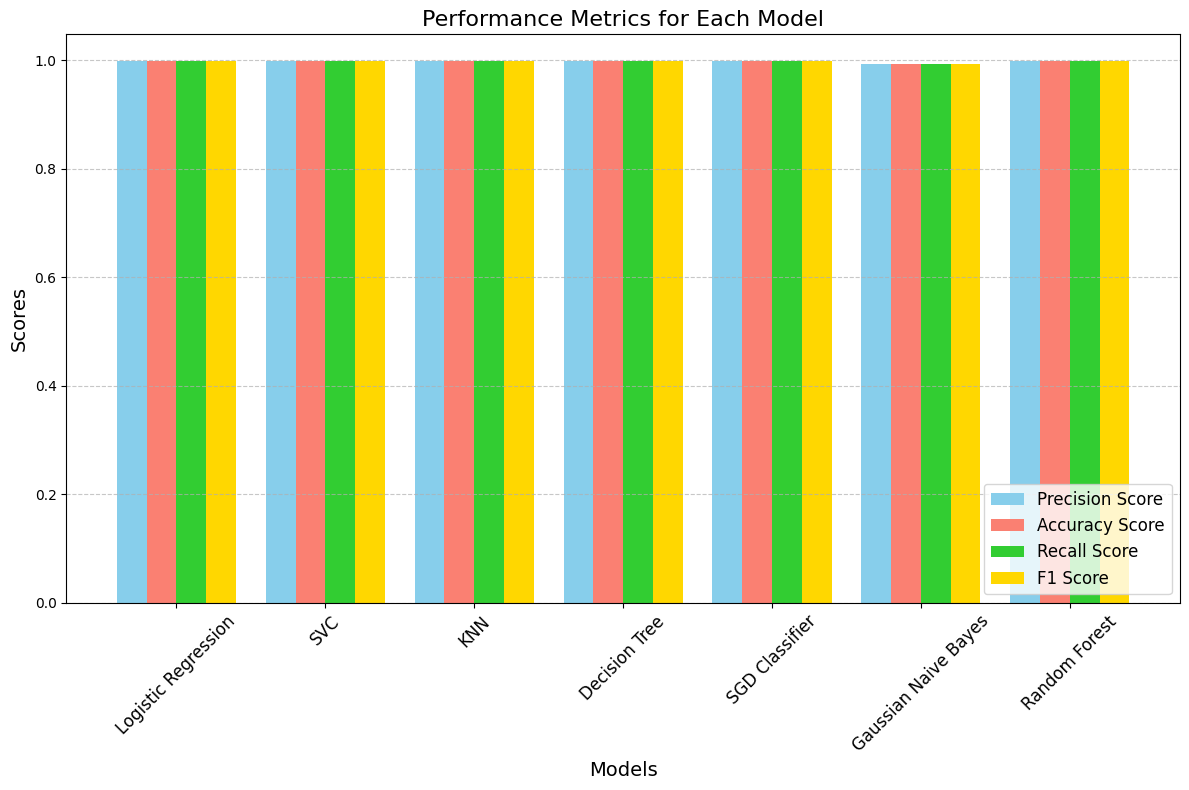

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure size
plt.figure(figsize=(12, 8))

# Extract metrics and models from the DataFrame
models = results_df["Model"]
precision_scores = results_df["Precision Score"]
accuracy_scores = results_df["Accuracy Score"]
recall_scores = results_df["Recall Score"]
f1_scores = results_df["F1 Score"]

# Bar width and positions
bar_width = 0.2
x = np.arange(len(models))

# Create bar plots for each metric
plt.bar(x - bar_width * 1.5, precision_scores, width=bar_width, label="Precision Score", color="skyblue")
plt.bar(x - bar_width * 0.5, accuracy_scores, width=bar_width, label="Accuracy Score", color="salmon")
plt.bar(x + bar_width * 0.5, recall_scores, width=bar_width, label="Recall Score", color="limegreen")
plt.bar(x + bar_width * 1.5, f1_scores, width=bar_width, label="F1 Score", color="gold")

# Add labels and title
plt.xlabel("Models", fontsize=14)
plt.ylabel("Scores", fontsize=14)
plt.title("Performance Metrics for Each Model", fontsize=16)
plt.xticks(x, models, rotation=45, fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [57]:
test_df = describe_dataset("/content/test.csv")
test_df.loc[test_df["label"] == "down", "label"] = 0
test_df.loc[test_df["label"] == "up", "label"] = 1

test_x = test_df.drop("label", axis=1)
test_y = test_df["label"].astype("int")

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']
Number of rows: 853 
Number of columns: 37

Labels: 
label
down    430
up      423
Name: count, dtype: int64

Missing values: False

Duplicate Rows: 0

Column data types after conversion:
label                object
nose_x              float64
nose_y              float64
nose_z              float64
nose_v              float64
left_shoulder_x     float64
left_shoulder_y     float64
left_shoulder_z     float64
l

In [61]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix

# Load and prepare the training data
train_df = describe_dataset("/content/train.csv")

# Convert labels 'down' and 'up' to 0 and 1 for training
train_df.loc[train_df["label"] == "down", "label"] = 0
train_df.loc[train_df["label"] == "up", "label"] = 1

# Prepare the feature matrix and labels for training
train_x = train_df.drop("label", axis=1)
train_y = train_df["label"].astype("int")

# Load and prepare the test data
test_df = describe_dataset("/content/test.csv")
test_df.loc[test_df["label"] == "down", "label"] = 0
test_df.loc[test_df["label"] == "up", "label"] = 1

# Prepare the feature matrix and labels for testing
test_x = test_df.drop("label", axis=1)
test_y = test_df["label"].astype("int")

# Initialize models
models = {
    "LR": LogisticRegression(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier()
}

# Train all models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(train_x, train_y)  # Fit the model to the training data

# Evaluate models on test data
testset_final_results = []

for name, model in models.items():
    # Evaluate model after training
    model_results = model.predict(test_x)

    p_score = precision_score(test_y, model_results, average="weighted")
    a_score = accuracy_score(test_y, model_results)
    r_score = recall_score(test_y, model_results, average="weighted")
    f1_score_result = f1_score(test_y, model_results, average="weighted")
    cm = confusion_matrix(test_y, model_results, labels=[0, 1])

    # Store results
    testset_final_results.append((name, p_score, a_score, r_score, f1_score_result, cm))

# Sort results by F1 score
testset_final_results.sort(key=lambda k: k[4], reverse=True)

# Create DataFrame from the results
eval_df = pd.DataFrame(testset_final_results, columns=["Model", "Precision score", "Accuracy score", "Recall score", "F1 score", "Confusion Matrix"])
eval_df = eval_df.sort_values(by=['F1 score'], ascending=False).reset_index(drop=True)

# Save evaluation results to CSV
eval_df.to_csv("evaluation.csv", sep=',', encoding='utf-8', index=False)
print(eval_df)


Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']
Number of rows: 4160 
Number of columns: 37

Labels: 
label
down    2127
up      2033
Name: count, dtype: int64

Missing values: False

Duplicate Rows: 0

Column data types after conversion:
label                object
nose_x              float64
nose_y              float64
nose_z              float64
nose_v              float64
left_shoulder_x     float64
left_shoulder_y     float64
left_shoulder_z     float6

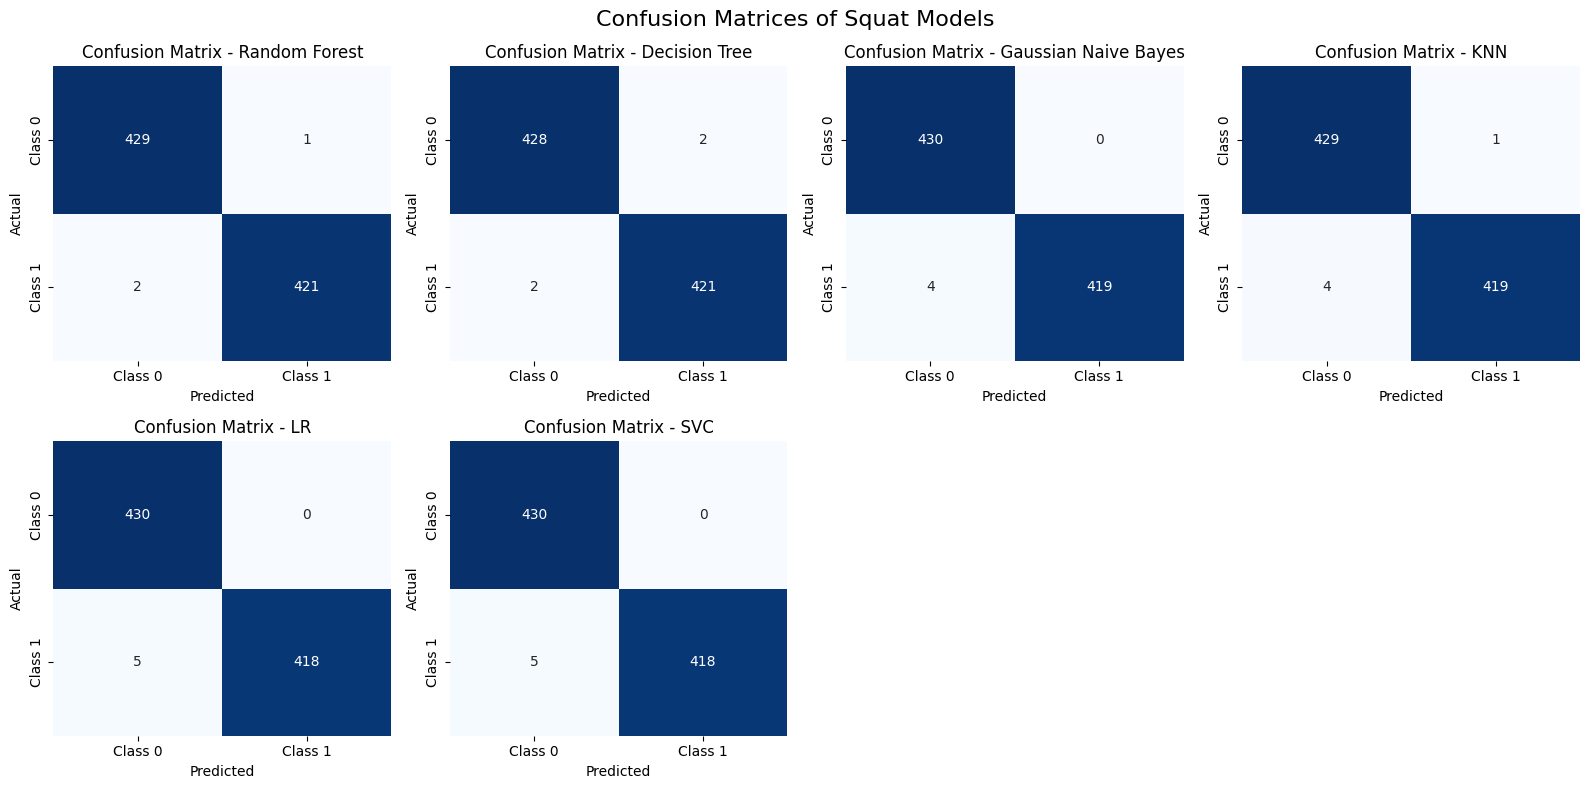

In [70]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate rows and columns dynamically
n_models = len(models)  # Number of models
cols = 4  # Number of columns
rows = math.ceil(n_models / cols)  # Calculate rows dynamically

# Create a grid matching the number of models
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, rows * 4))
fig.suptitle("Confusion Matrices of Squat Models", fontsize=16)

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through each model and plot confusion matrix
for idx, row in eval_df.iterrows():
    cm = row["Confusion Matrix"]
    model_name = row["Model"]

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"], ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix - {model_name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

# Remove any extra axes if there are unused subplots
for i in range(n_models, len(axes)):
    fig.delaxes(axes[i])

# Display the confusion matrix plots
plt.tight_layout()
plt.show()


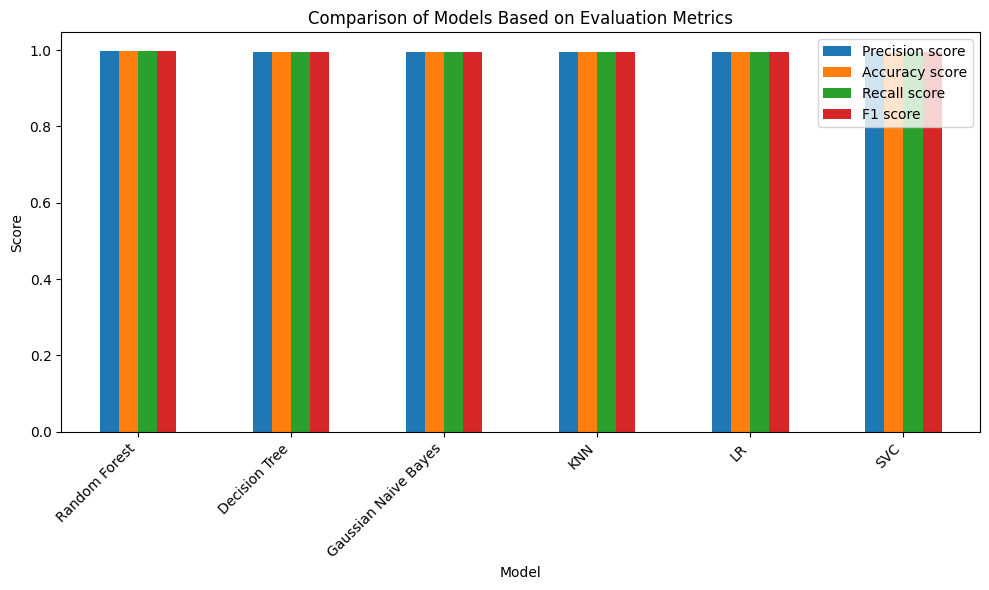

In [66]:
# Plot evaluation metrics (Precision, Accuracy, Recall, F1)
metrics_df = eval_df[["Model", "Precision score", "Accuracy score", "Recall score", "F1 score"]].set_index("Model")

# Plot all metrics
metrics_df.plot(kind="bar", figsize=(10, 6))
plt.title("Comparison of Models Based on Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
import pickle
import os

# Create a directory in Colab to save your models
save_directory = '/Lunges_FYP_Model'

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save the SGDC model
with open(os.path.join(save_directory, 'sgdc_model.pkl'), 'wb') as sgdc_file:
    pickle.dump(models["SGDC"], sgdc_file)

# Save the Standard Scaler
with open(os.path.join(save_directory, 'input_scaler.pkl'), 'wb') as scaler_file:
    pickle.dump(sc, scaler_file)
print("Logistic Regression model and scaler saved successfully!")

# Zip the directory
!zip -r Lunges_FYP_Model.zip /Lunges_FYP_Model

# Download the zip file
from google.colab import files
files.download('Lunges_FYP_Model.zip')


Analyze Bad Pose


In [ ]:
from math import sqrt


def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)


def calculate_distance(pointX, pointY) -> float:
    '''
    Calculate a distance between 2 points
    '''

    x1, y1 = pointX
    x2, y2 = pointY

    return

In [ ]:
df=pd.read_csv("/content/analyze_pose.csv")
df.head(5)

In [ ]:
df["ratio_feet_shoulder"] = df["feet_width"] / df["shoulder_width"]

# Round up the value
# df["ratio_feet_shoulder"] = [round(row, 1) for row in df["ratio_feet_shoulder"]]

df.head(5)

In [ ]:
mean = df["ratio_feet_shoulder"].mean(axis=0)
min_val = df["ratio_feet_shoulder"].min()
max_val = df["ratio_feet_shoulder"].max()

print(
f'''
Mean value of the ratio between shoulder width and 2 foot: {mean}
Max value of the ratio between shoulder width and 2 foot: {max_val}
Min value of the ratio between shoulder width and 2 foot: {min_val}
'''
)

Feet distance / shoulder width < 1.2
=>Foot placement is too tight
Feet distance / shoulder width > 2.8
=> Foot placement is too wide
Else: => Correct form

In [ ]:
df["ratio_knee_feet"] = df["knee_width"] / df["feet_width"]
# df["ratio_knee_feet"] = [round(row, 1) for row in df["ratio_knee_feet"]] # round up

df.head(5)

In [ ]:
mean = df["ratio_knee_feet"].mean(axis=0)
min_val = df["ratio_knee_feet"].min()
max_val = df["ratio_knee_feet"].max()

print(
f'''
Mean value of the ratio between 2 knee width and 2 foot: {mean}
Max value of the ratio between 2 knee width and 2 foot: {max_val}
Min value of the ratio between 2 knee width and 2 foot: {min_val}
'''
)

UP

In [ ]:
df_ration_knee_feet = df[ df["stage"] == "up" ]["ratio_knee_feet"]

mean = df_ration_knee_feet.mean(axis=0)
min_val = df_ration_knee_feet.min()
max_val = df_ration_knee_feet.max()

print(
f'''
Mean value of the ratio between 2 knee width and 2 foot in UP position: {mean}
Max value of the ratio between 2 knee width and 2 foot in UP position: {max_val}
Min value of the ratio between 2 knee width and 2 foot in UP position: {min_val}
'''
)

Middle

In [ ]:
df_ration_knee_feet = df[ df["stage"] == "middle" ]["ratio_knee_feet"]

mean = df_ration_knee_feet.mean(axis=0)
min_val = df_ration_knee_feet.min()
max_val = df_ration_knee_feet.max()

print(
f'''
Mean value of the ratio between 2 knee width and 2 foot in MIDDLE position: {mean}
Max value of the ratio between 2 knee width and 2 foot in MIDDLE position: {max_val}
Min value of the ratio between 2 knee width and 2 foot in MIDDLE position: {min_val}
'''
)

Down

In [ ]:
df_ration_knee_feet = df[ df["stage"] == "down" ]["ratio_knee_feet"]

mean = df_ration_knee_feet.mean(axis=0)
min_val = df_ration_knee_feet.min()
max_val = df_ration_knee_feet.max()

print(
f'''
Mean value of the ratio between 2 knee width and 2 foot in DOWN position: {mean}
Max value of the ratio between 2 knee width and 2 foot in DOWN position: {max_val}
Min value of the ratio between 2 knee width and 2 foot in DOWN position: {min_val}
'''
)

In [ ]:
test = df[ (df["ratio_knee_feet"] == 0.7) & (df["stage"] == "down") ]
print(df.head(10))
print(test)

# df = df[ (df["ratio_knee_feet"] != 0.4) ]

Conclusion
According to the analyzed data extracted from the dataset:

In UP position:

Knee distance usually tighter compare to foot distance
The mean ratio between knee/foot is 0.63
Conclusion:
Knee distance / foot width < 0.5 => 2 Knees are too tight
Knee distance / foot width > 1.0 => 2 Knees are too wide
Else: => Correct form
In MIDDLE position:

Knee distance usually equals compare to foot distance
The mean ratio between knee/foot is 0.8
Conclusion:
Knee distance / foot width < 0.7 => 2 Knees are too tight
Knee distance / foot width > 1.0 => 2 Knees are too wide
Else: => Correct form
In DOWN position:

Knee distance usually equals or a little bit wider compare to foot distance
The mean ratio between knee/foot is 0.8
Conclusion:
Knee distance / foot width < 0.7 => 2 Knees are too tight
Knee distance / foot width > 1.1 => 2 Knees are too wide
Else: => Correct form\

In [ ]:
VIDEO_DEMO_PATH1 = "/content/4265287-uhd_3840_2160_30fps.mp4"
VIDEO_DEMO_PATH2 = "/content/4921644-hd_1066_1920_25fps.mp4"

In [ ]:
# Load model for counter
with open("/content/logistic_regression_model.pkl", "rb") as f:
    count_model = pickle.load(f)

In [ ]:
# List of important landmarks (using the official MediaPipe PoseLandmark enum names)
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE"
]

# Create headers for the CSV or DataFrame (x, y, z, visibility for each landmark)
headers = ["label"]  # Label column
for lm in IMPORTANT_LMS:
    headers += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

# Function to extract keypoints from mediapipe results
def extract_important_keypoints(results) -> list:
    '''
    Extract important keypoints from mediapipe pose detection
    '''
    landmarks = results.pose_landmarks.landmark  # Get the list of landmarks

    keypoints = []
    for lm in IMPORTANT_LMS:
        # Get each landmark by its enum value
        keypoint = landmarks[mp_pose.PoseLandmark[lm].value]
        keypoints.extend([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])

    return keypoints  # Return the flattened list of x, y, z, v for each landmark

# Function to rescale a frame to a percentage of its original size
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent / 100)  # Rescale width
    height = int(frame.shape[0] * percent / 100)  # Rescale height
    dim = (width, height)  # New dimensions
    return cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)  # Resize the frame


In [ ]:
import math


def calculate_distance(pointX, pointY) -> float:
    '''
    Calculate a distance between 2 points
    '''

    x1, y1 = pointX
    x2, y2 = pointY

    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


def analyze_foot_knee_placement(results, stage: str, foot_shoulder_ratio_thresholds: list, knee_foot_ratio_thresholds: dict, visibility_threshold: int) -> dict:
    '''
    Calculate the ratio between the foot and shoulder for FOOT PLACEMENT analysis

    Calculate the ratio between the knee and foot for KNEE PLACEMENT analysis

    Return result explanation:
        -1: Unknown result due to poor visibility
        0: Correct knee placement
        1: Placement too tight
        2: Placement too wide
    '''
    analyzed_results = {
        "foot_placement": -1,
        "knee_placement": -1,
    }

    landmarks = results.pose_landmarks.landmark

    # * Visibility check of important landmarks for foot placement analysis
    left_foot_index_vis = landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].visibility
    right_foot_index_vis = landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].visibility

    left_knee_vis = landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].visibility
    right_knee_vis = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].visibility

    # If visibility of any keypoints is low cancel the analysis
    if (left_foot_index_vis < visibility_threshold or right_foot_index_vis < visibility_threshold or left_knee_vis < visibility_threshold or right_knee_vis < visibility_threshold):
        return analyzed_results

    # * Calculate shoulder width
    left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
    right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
    shoulder_width = calculate_distance(left_shoulder, right_shoulder)

    # * Calculate 2-foot width
    left_foot_index = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].x, landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value].y]
    right_foot_index = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value].y]
    foot_width = calculate_distance(left_foot_index, right_foot_index)

    # * Calculate foot and shoulder ratio
    foot_shoulder_ratio = round(foot_width / shoulder_width, 1)

    # * Analyze FOOT PLACEMENT
    min_ratio_foot_shoulder, max_ratio_foot_shoulder = foot_shoulder_ratio_thresholds
    if min_ratio_foot_shoulder <= foot_shoulder_ratio <= max_ratio_foot_shoulder:
        analyzed_results["foot_placement"] = 0
    elif foot_shoulder_ratio < min_ratio_foot_shoulder:
        analyzed_results["foot_placement"] = 1
    elif foot_shoulder_ratio > max_ratio_foot_shoulder:
        analyzed_results["foot_placement"] = 2

    # * Visibility check of important landmarks for knee placement analysis
    left_knee_vis = landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].visibility
    right_knee_vis = landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].visibility

    # If visibility of any keypoints is low cancel the analysis
    if (left_knee_vis < visibility_threshold or right_knee_vis < visibility_threshold):
        print("Cannot see foot")
        return analyzed_results

    # * Calculate 2 knee width
    left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
    right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
    knee_width = calculate_distance(left_knee, right_knee)

    # * Calculate foot and shoulder ratio
    knee_foot_ratio = round(knee_width / foot_width, 1)

    # * Analyze KNEE placement
    up_min_ratio_knee_foot, up_max_ratio_knee_foot = knee_foot_ratio_thresholds.get("up")
    middle_min_ratio_knee_foot, middle_max_ratio_knee_foot = knee_foot_ratio_thresholds.get("middle")
    down_min_ratio_knee_foot, down_max_ratio_knee_foot = knee_foot_ratio_thresholds.get("down")

    if stage == "up":
        if up_min_ratio_knee_foot <= knee_foot_ratio <= up_max_ratio_knee_foot:
            analyzed_results["knee_placement"] = 0
        elif knee_foot_ratio < up_min_ratio_knee_foot:
            analyzed_results["knee_placement"] = 1
        elif knee_foot_ratio > up_max_ratio_knee_foot:
            analyzed_results["knee_placement"] = 2
    elif stage == "middle":
        if middle_min_ratio_knee_foot <= knee_foot_ratio <= middle_max_ratio_knee_foot:
            analyzed_results["knee_placement"] = 0
        elif knee_foot_ratio < middle_min_ratio_knee_foot:
            analyzed_results["knee_placement"] = 1
        elif knee_foot_ratio > middle_max_ratio_knee_foot:
            analyzed_results["knee_placement"] = 2
    elif stage == "down":
        if down_min_ratio_knee_foot <= knee_foot_ratio <= down_max_ratio_knee_foot:
            analyzed_results["knee_placement"] = 0
        elif knee_foot_ratio < down_min_ratio_knee_foot:
            analyzed_results["knee_placement"] = 1
        elif knee_foot_ratio > down_max_ratio_knee_foot:
            analyzed_results["knee_placement"] = 2

    return analyzed_results

In [ ]:
VIDEO_DEMO_PATH1 = "/content/4265287-uhd_3840_2160_30fps.mp4"
VIDEO_DEMO_PATH2 = "/content/4921644-hd_1066_1920_25fps.mp4"

In [ ]:
from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture(VIDEO_DEMO_PATH1)

# Counter vars
counter = 0
current_stage = ""
PREDICTION_PROB_THRESHOLD = 0.7

# Error vars
VISIBILITY_THRESHOLD = 0.6
FOOT_SHOULDER_RATIO_THRESHOLDS = [1.2, 2.8]
KNEE_FOOT_RATIO_THRESHOLDS = {
    "up": [0.5, 1.0],
    "middle": [0.7, 1.0],
    "down": [0.7, 1.1],
}

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        if not ret:
            break

        # Reduce size of a frame
        image = rescale_frame(image, 50)

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)
        if not results.pose_landmarks:
            continue

        # Recolor image from RGB to BGR for display
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=1))

        try:
            # * Model prediction for SQUAT counter
            row = extract_important_keypoints(results)
            X = pd.DataFrame([row], columns=headers[1:])

            # Make prediction and its probability
            predicted_class = count_model.predict(X)[0]
            predicted_class = "down" if predicted_class == 0 else "up"
            prediction_probabilities = count_model.predict_proba(X)[0]
            prediction_probability = round(prediction_probabilities[prediction_probabilities.argmax()], 2)

            # Evaluate model prediction
            if predicted_class == "down" and prediction_probability >= PREDICTION_PROB_THRESHOLD:
                current_stage = "down"
            elif current_stage == "down" and predicted_class == "up" and prediction_probability >= PREDICTION_PROB_THRESHOLD:
                current_stage = "up"
                counter += 1

            analyzed_results = analyze_foot_knee_placement(results=results, stage=current_stage,
                                                           foot_shoulder_ratio_thresholds=FOOT_SHOULDER_RATIO_THRESHOLDS,
                                                           knee_foot_ratio_thresholds=KNEE_FOOT_RATIO_THRESHOLDS,
                                                           visibility_threshold=VISIBILITY_THRESHOLD)

            foot_placement_evaluation = analyzed_results["foot_placement"]
            knee_placement_evaluation = analyzed_results["knee_placement"]

            # Evaluate FOOT PLACEMENT error
            foot_placement = {
                -1: "UNK",
                0: "Correct",
                1: "Too tight",
                2: "Too wide"
            }[foot_placement_evaluation]

            # Evaluate KNEE PLACEMENT error
            knee_placement = {
                -1: "UNK",
                0: "Correct",
                1: "Too tight",
                2: "Too wide"
            }[knee_placement_evaluation]

            # Visualization
            cv2.rectangle(image, (0, 0), (500, 60), (245, 117, 16), -1)

            # Display class
            cv2.putText(image, "COUNT", (10, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, f'{str(counter)}, {predicted_class}, {str(prediction_probability)}', (5, 40),
                        cv2.FONT_HERSHEY_COMPLEX, .7, (255, 255, 255), 2, cv2.LINE_AA)

            # Display Foot placement
            cv2.putText(image, "FOOT", (200, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, foot_placement, (195, 40), cv2.FONT_HERSHEY_COMPLEX, .7, (255, 255, 255), 2, cv2.LINE_AA)

            # Display knee placement
            cv2.putText(image, "KNEE", (330, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, knee_placement, (325, 40), cv2.FONT_HERSHEY_COMPLEX, .7, (255, 255, 255), 2, cv2.LINE_AA)

        except Exception as e:
            print(f"Error: {e}")

        # Use cv2_imshow instead of cv2.imshow
        cv2_imshow(image)

        # Press Q to close cv2 window
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [ ]:
import pickle
import os

# Create a directory in Colab to save your models
save_directory = 'Lunges_FYP_Model/Deep_Learning_Model'  # Removed leading slash

# Create the directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save the model
with open(os.path.join(save_directory, 'Lunges_Deep_Learning_Model.pkl'), 'wb') as svc_file:
    pickle.dump(model, svc_file)  # Ensure 'model' is defined

print("Model saved successfully!")

# Zip the directory
!zip -r Lunges_FYP_Model.zip Lunges_FYP_Model  # Removed leading slash

# Download the zip file
from google.colab import files
files.download('Lunges_FYP_Model.zip')
